In [1]:
# compiled radstats -- symmetric cloud distribution analysis 
# (1) examine the symmetric cloud distribution within tropics vs extratropics
# (2) examine the cloud difference (obs - model) as a function of symmetric cloud 
#     (to understand the difference between CLR-CLD_SYM_LOW vs CTRL_SYM_LOW)
# initial built: 2025/05/27

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
expid = 'full_CTRL'
instrument = 'amsua'
channel    = 'ch1'

fig_dir = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/python_codes/figures/demo_use/'
save_fig = False

In [5]:
### read omf csv (large file!)
fn = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files/{expid}/omf_stats_{instrument}_{channel}_2022062000_2022081000.csv'
df = pd.read_csv(fn)

# screen the data:
dfs = df[abs(df['omf_ges']) < 1e3]

In [7]:
### sort the data based on regions
regions=['sea']
lats   =['Global']
#regions=['land','sea']
#lats   =['Global','90S-60S','60S-40S','40S-20S','20S-0','0-20N','20N-40N','40N-60N','60N-90N']
#lats   =['60S-40S','40S-20S','20S-0','0-20N','20N-40N','40N-60N']
#lats   =['60S-30S','30S-0','0-30N','30N-60N']

#lats = ['extratropics', 'tropics']


adf={} # "a"nalysis "d"ata "f"rame

for rg in regions:
    adf[rg] = {}  # Initialize the nested dictionary for each experiment
    if rg == 'land':
        dftmp = dfs.loc[ dfs['fland']>=0.99 ]
    elif rg == 'sea':
        dftmp = dfs.loc[ dfs['fwater']>=0.99 ]
        
    for lat in lats:

        if lat == 'Global':
            adf[rg][lat] = dftmp
        elif lat == '90S-60S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-60) & (dftmp['lat']>-90) ]
        elif lat == '60S-40S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-40) & (dftmp['lat']>-60) ]
        elif lat == '40S-20S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-20) & (dftmp['lat']>-40) ]
        elif lat == '20S-0':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=0) & (dftmp['lat']>-20) ]
        elif lat == '0-20N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=20) & (dftmp['lat']>0) ]
        elif lat == '20N-40N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=40) & (dftmp['lat']>20) ]
        elif lat == '40N-60N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=60) & (dftmp['lat']>40) ]
        elif lat == '60N-90N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=90) & (dftmp['lat']>60) ]
        elif lat == '60S-30S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-30) & (dftmp['lat']>-60) ]
        elif lat == '30S-0':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=  0) & (dftmp['lat']>-30) ]
        elif lat == '0-30N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<= 30) & (dftmp['lat']>  0) ]
        elif lat == '30N-60N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<= 60) & (dftmp['lat']> 30) ]
        elif lat == 'extratropics':
            adf[rg][lat] = dftmp.loc[ np.abs(dftmp['lat'])>30 ]
        elif lat == 'tropics':
            adf[rg][lat] = dftmp.loc[ np.abs(dftmp['lat'])<=30 ]
        

In [8]:
#adf['sea']['Global'].keys()

mask = (
    ((adf['sea']['Global']['clw_obs'] <= 0.05) & (adf['sea']['Global']['clw_bg_nobc_ges'] <= 0.05)) |
    ((adf['sea']['Global']['clw_obs'] >= 0.05) & (adf['sea']['Global']['clw_bg_nobc_ges'] >= 0.05))
)

consistent_rows = adf['sea']['Global'][mask]

cloud_diff = consistent_rows['clw_obs'] - consistent_rows['clw_bg_nobc_ges']
cloud_sym  = 0.5*( consistent_rows['clw_obs'] + consistent_rows['clw_bg_nobc_ges'] )


# histogram:
x_edges = np.linspace(  0, 0.5, 41)  
y_edges = np.linspace( -1, 1, 81)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

x = cloud_sym
y = cloud_diff

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

/tmp/ipykernel_2952756/1930593617.py:7: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_2952756/1930593617.py:16: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


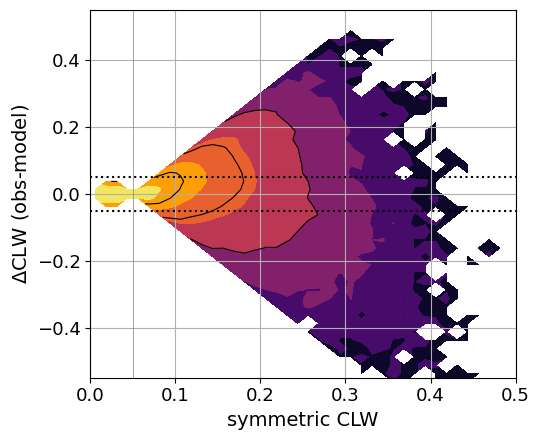

In [9]:

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,4.5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
#ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('symmetric CLW',fontsize=14)
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_ylabel(rf'$\Delta$CLW (obs-model)',fontsize=14)

ax.set_xlim([0,0.5])
ax.set_ylim([-0.55,0.55])

ax.axhline( 0.05, color='black', linestyle=':')
ax.axhline(-0.05, color='black', linestyle=':')
ax.axvline( 0.05, color='gray', linestyle='-', linewidth=0.5)

ax.tick_params(axis='x', labelsize=13)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=13)  # Set the size to 14 points
ax.grid(True)
#ax.set_title(f'{expid_short[expid]} ',fontsize=16)
plt.tight_layout()

if save_fig:
    plt.savefig(f'{fig_dir}/symmetric_cloud_vs_cloud_difference.png', dpi=300, bbox_inches='tight')

In [10]:
# Plot the conditional mean

nx,ny = np.shape(hist)
mean_ctrl   = np.zeros(nx)
mean_clrcld = np.zeros(nx)

idx_start = np.where( np.abs(y_edges_out+0.05)<1e-3)[0][0]
idx_end   = np.where( np.abs(y_edges_out-0.05)<1e-3)[0][0]

for i in range(nx):
    mean_ctrl[i]   = np.dot(hist[i,:],yc)/sum(hist[i,:])
    mean_clrcld[i] = np.dot(hist[i,idx_start:idx_end+1],yc[idx_start:idx_end+1])/sum(hist[i,idx_start:idx_end+1])

/tmp/ipykernel_2952756/4091425783.py:12: RuntimeWarning: invalid value encountered in scalar divide
  mean_clrcld[i] = np.dot(hist[i,idx_start:idx_end+1],yc[idx_start:idx_end+1])/sum(hist[i,idx_start:idx_end+1])


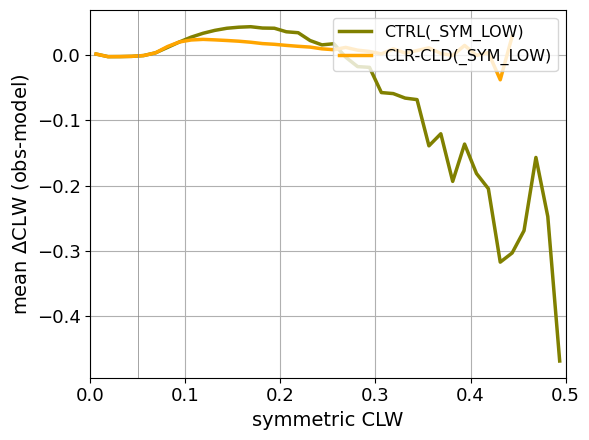

In [11]:

## Plot figure
fig, ax = plt.subplots(figsize=(6,4.5))

ax.plot(xc, mean_ctrl,   linewidth=2.5, color='olive',  label='CTRL(_SYM_LOW)')
ax.plot(xc, mean_clrcld, linewidth=2.5, color='orange', label='CLR-CLD(_SYM_LOW)')

ax.set_xlabel('symmetric CLW',fontsize=14)
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_ylabel(rf'mean $\Delta$CLW (obs-model)',fontsize=14)

ax.set_xlim([0,0.5])

ax.tick_params(axis='x', labelsize=13)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=13)  # Set the size to 14 points
ax.legend(fontsize=11.5, loc='upper right')
ax.grid(True)
ax.axvline( 0.05, color='gray', linestyle='-', linewidth=0.5)

#ax.set_title(f'{expid_short[expid]} ',fontsize=16)
plt.tight_layout()

if save_fig:
    plt.savefig(f'{fig_dir}/conditional_mean_symmetric_cloud_vs_cloud_difference.png', dpi=300, bbox_inches='tight')

In [79]:
##
## to examine the cloud distribution in different regions:
## 

# irregular bins:
first_bin = [0.005, 0.010]
dx = 0.005
x_max = 0.2  # adjust this to your desired upper limit

# Generate remaining edges starting from 0.01
remaining_edges = np.arange(first_bin[1] + dx, x_max + dx, dx)

# Combine first bin with the rest
x_edges = np.concatenate((first_bin, remaining_edges))


x_center = 0.5*(x_edges[:-1] + x_edges[1:])
dx = x_edges[1] - x_edges[0]

hist_counts={};
hist_total ={};


for lat in lats:
    symcloud = 0.5*( adf['sea'][lat]['clw_obs'] + adf['sea'][lat]['clw_bg_nobc_ges'] )
    hist_total[lat] = len(symcloud)
    hist_counts[lat], bin_edges = np.histogram(symcloud, bins=x_edges)



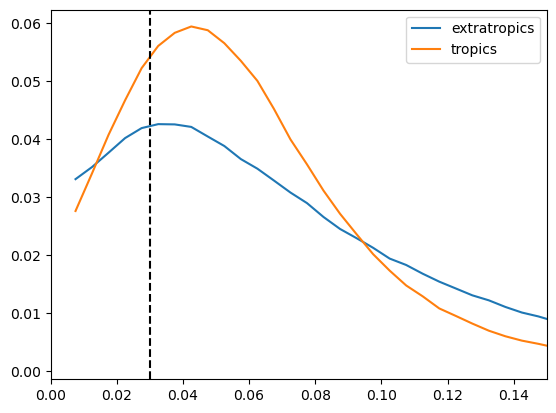

In [80]:
##
## to examine the cloud distribution in different regions (plot)
## 

for lat in lats:
    plt.plot(x_center[:], hist_counts[lat][:]/hist_total[lat], label=f'{lat}')
#    plt.plot(x_center[1:], hist_counts[lat][1:], label=f'{lat}')

plt.xlim([0,0.15])
plt.axvline(0.03, color='black', linestyle='--')
plt.legend()


In [39]:
x_edges

array([0.   , 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135,
       0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 ,
       0.185, 0.19 , 0.195, 0.2  ])